## Introduction


The starting code for this project can be found [here](https://colab.research.google.com/drive/1bLGxKdldwqnMVA5x4neY7-l_8fKGWQYI?usp=sharing) as provided by huggingface. The starting code runs a the base visualbert model and is a good starting point to understand how to generate visual embeddings for visualbert. I would suggest reading the paper to understand the shortcomings that this approach produces, as it does not reach ideal accuracy for this model.

### Install Detectron2

In [ ]:
import torch
torch.__version__

'2.0.0+cu118'

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#%%capture
#!pip install pyyaml==5.1
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4'

### Imports

In [ ]:
import torch, torchvision
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
from copy import deepcopy

In [ ]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures.image_list import ImageList
from detectron2.data import transforms as T
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputs
from detectron2.structures.boxes import Boxes
from detectron2.layers import nms
from detectron2 import model_zoo
from detectron2.config import get_cfg

### Download the VQA v2 Validation Set

In [ ]:
# questions
#%%capture
#!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip --no-check-certificate
#!unzip v2_Questions_Val_mscoco.zip

In [ ]:
# images
#%%capture
#!wget http://images.cocodataset.org/zips/val2014.zip --no-check-certificate
#!unzip val2014.zip

In [ ]:
# answers
#%%capture
#!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip --no-check-certificate
#!unzip v2_Annotations_Val_mscoco.zip

### Hateful Memes Dataset

In [ ]:
path = './'

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from skimage import io
import transformers
from transformers import BertTokenizer, VisualBertModel, VisualBertPreTrainedModel, VisualBertConfig, AutoTokenizer, VisualBertForPreTraining
from PIL import Image
import os
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Cuda Check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

print(torch.__version__)
torch.cuda.is_available()

cuda
2.0.0+cu118


True

In [ ]:
train_data = pd.read_json(path + "/hateful_memes/train.jsonl", lines=True)

print(train_data)

         id            img  label  \
0     42953  img/42953.png      0   
1     23058  img/23058.png      0   
2     13894  img/13894.png      0   
3     37408  img/37408.png      0   
4     82403  img/82403.png      0   
...     ...            ...    ...   
8495  10423  img/10423.png      1   
8496  98203  img/98203.png      1   
8497  36947  img/36947.png      1   
8498  16492  img/16492.png      1   
8499  15937  img/15937.png      1   

                                                   text  
0      its their character not their color that matters  
1     don't be afraid to love again everyone is not ...  
2                              putting bows on your pet  
3     i love everything and everybody! except for sq...  
4     everybody loves chocolate chip cookies, even h...  
...                                                 ...  
8495                  nobody wants to hang auschwitz me  
8496  when god grants you a child after 20 years of ...  
8497  gays on social media: equal

In [ ]:
# create PyTorch dataset from the given files/directories
# make sure paths are correct

# each sample has keys: "id", "image", "label", and "text"

class TrainHMDataset(Dataset):
  def __init__(self, jsonl_file, root_dir, transform = None):
    self.annotations = pd.read_json(jsonl_file, lines=True)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return self.annotations.shape[0]

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    id = self.annotations["id"][idx]

    img_name = os.path.join(self.root_dir, self.annotations['img'][idx])
    image = io.imread(img_name)
    
    # Occasionally for some reason the image can import as a 4 channel image instead of 3. Check and trim if necessary
    if image.shape[2] == 4:
      image = image[:, :, :3]
    
    #print("Image: ", image.shape)

    label = self.annotations["label"][idx]

    text = self.annotations["text"][idx]

    sample = {"id": id, "image":image, "label":label, "text":text}

    if self.transform:
      sample["image"] = self.transform(sample["image"])

    return sample

In [ ]:
# add transformations to resize and center images
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(232, antialias=False),
                                transforms.CenterCrop(224)])

train_dataset = TrainHMDataset(jsonl_file=path+"/hateful_memes/train.jsonl", root_dir=path+"/hateful_memes/", transform=transform)

8500
0 42953 0 its their character not their color that matters
2000 94620 0 we now have reason to believe trump ripped the tag off his matress in 1987
4000 41057 1 i like my korean women the way i like my microwaves hot, clean and will kill any baby i put inside of it
6000 68934 0 relax... we're all crazy... it's not a competition


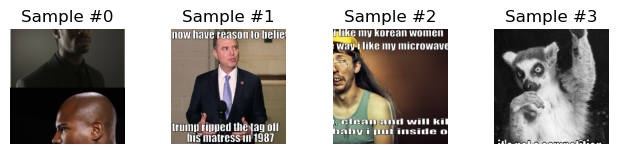

In [ ]:
# visualize images

fig = plt.figure()

print(len(train_dataset))

for i in range(4):
  sample = train_dataset[i * 2000] # show every 2000th image 

  print(i*2000, sample["id"], sample["label"], sample["text"])

  ax = plt.subplot(1, 4, i + 1)
  plt.tight_layout()
  ax.set_title('Sample #{}'.format(i))
  ax.axis('off')
  plt.imshow(sample["image"].cpu().numpy().transpose((1, 2, 0)))

plt.show()
 

torch.Size([2, 3, 224, 224])

tensor(67849)
tensor(0)
fuck you america!


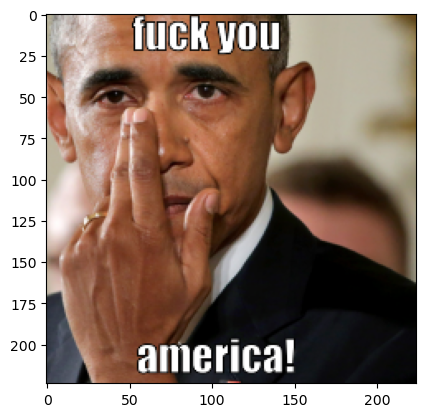

tensor(92041)
tensor(1)
sign says "take a quarter"  takes two


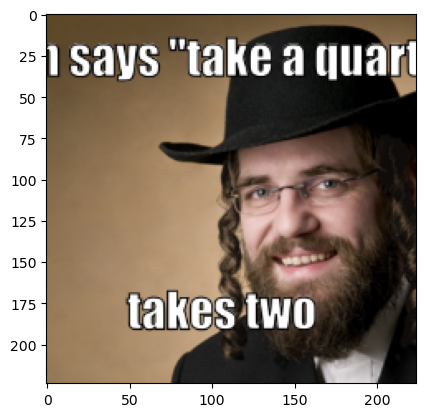

In [ ]:
# testing out dataloader / batches

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# dataloader is an iterable of batches
# each batch is a dictionary, accesssing each key gives a batch of the
# corresponding entries.  



# Check for random 4 dimension entries
# dimensions = []
# for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
#     #print("Image Shape: ", data['image'].shape)
#     N, H, W, C = data['image'].shape
#     if H not in dimensions:
#         dimensions.append(H)
#     if W not in dimensions:
#         dimensions.append(W)
#     if C not in dimensions:
#         dimensions.append(C)

#print("Unique Values: ", list(set(dimensions)))
        

sample_batch = next(iter(train_dataloader))

# 64 x C x W x H batch of images
print(sample_batch["image"].shape)
print()

print(sample_batch["id"][0])
print(sample_batch["label"][0])
print(sample_batch["text"][0])

plt.imshow(sample_batch["image"][0].cpu().numpy().transpose((1, 2, 0)))
plt.show()

print(sample_batch["id"][1])
print(sample_batch["label"][1])
print(sample_batch["text"][1])

plt.imshow(sample_batch["image"][1].cpu().numpy().transpose((1, 2, 0)))
plt.show()


### Load Examples
The next few cells show how to get an example from the VQA v2 dataset. We will only use the image from the example.

In [ ]:
with open('v2_OpenEnded_mscoco_val2014_questions.json') as f:
    q = json.load(f)

In [ ]:
with open('v2_mscoco_val2014_annotations.json') as f:
    a = json.load(f)

In [ ]:
idx = 1500

In [ ]:
question_info = q["questions"][idx]
image_id = question_info['image_id']
question1 = question_info['question']
question_id = question_info['question_id']

In [ ]:
answer_info = a['annotations'][idx]
answer_word1 = answer_info['multiple_choice_answer']
assert question_id == answer_info['question_id']

In [ ]:
print("Question Info: ", question_info)
print("Question: ", question1)
print("Answer Info: ", answer_info)
print("Answer Word: ", answer_word1)

Question Info:  {'image_id': 693, 'question': 'What is the girl standing on?', 'question_id': 693001}
Question:  What is the girl standing on?
Answer Info:  {'question_type': 'what is the', 'multiple_choice_answer': 'skateboard', 'answers': [{'answer': 'skateboard', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'skateboard', 'answer_confidence': 'maybe', 'answer_id': 2}, {'answer': 'skateboard', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'skateboard', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'skateboard', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'skateboard', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'skateboard', 'answer_confidence': 'yes', 'answer_id': 7}, {'answer': 'skateboard', 'answer_confidence': 'yes', 'answer_id': 8}, {'answer': 'skateboard', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'skateboard', 'answer_confidence': 'yes', 'answer_id': 10}], 'image_id': 693, 'answer_type': 'other', 'question_id'

In [ ]:
img1 = plt.imread(f'val2014/COCO_val2014_{image_id:012d}.jpg')

# Detectron expects BGR images
img_bgr1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)

In [ ]:
print(img1.shape)

(428, 640, 3)


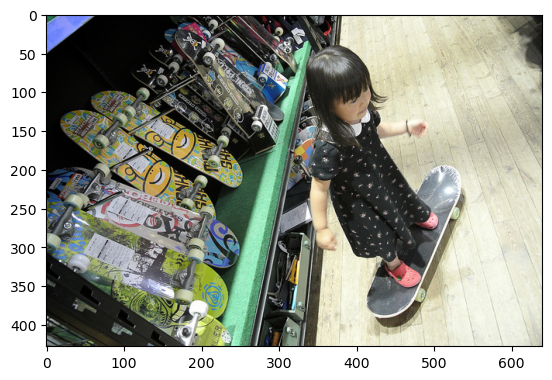

In [ ]:
plt.imshow(img1)
plt.show()

In [ ]:
question1

'What is the girl standing on?'

In [ ]:
answer_word1

'skateboard'

### Taking another image for a "batch"

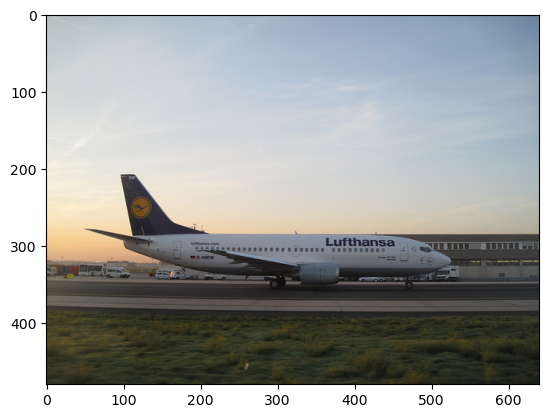

Image:  (480, 640, 3) <class 'numpy.ndarray'>


In [ ]:
idx = 2000

question_info = q["questions"][idx]
image_id = question_info['image_id']
question2 = question_info['question']
question_id = question_info['question_id']
answer_info = a['annotations'][idx]
answer_word2 = answer_info['multiple_choice_answer']

img2 = plt.imread(f'val2014/COCO_val2014_{image_id:012d}.jpg')

# Detectron expects BGR images
img_bgr2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
plt.imshow(img2)
plt.show()
print("Image: ", img_bgr2.shape, type(img_bgr2))

In [ ]:
img2.shape # Note that images are differently-sized

(480, 640, 3)

In [ ]:
question2

'What is wrote on the side of the plane?'

In [ ]:
answer_word2

'lufthansa'

### Using custom images

In [ ]:
question3 = sample_batch['text'][0]
question4 = sample_batch['text'][1]

In [ ]:
label3 = sample_batch['label'][0]
label4 = sample_batch['label'][1]
print("Label3: ", label3)
temp = ['False' if val.item() == 0 else 'True' for val in [label3, label4]]
print(temp)

Label3:  tensor(0)
['False', 'True']


In [ ]:
#print("Pre Reisize: ", sample_batch['image'][0].shape)
#img3 = sample_batch['image'][0].permute(1, 2, 0).cpu().numpy()
#img4 = sample_batch['image'][1].permute(1, 2, 0).cpu().numpy()
#print("Image: ", img3.shape, img4.shape)


img3 = sample_batch['image'][0].to(device)
img4 = sample_batch['image'][1].to(device)
print(type(img3), type(img4))
#print(img3.device, img4.device)

<class 'torch.Tensor'> <class 'torch.Tensor'>


### Load Config and Model Weights

I am using the MaskRCNN ResNet-101 FPN checkpoint, but you can use any checkpoint of your preference. This checkpoint is pre-trained on the COCO dataset. You can check other checkpoints/configs on the [Model Zoo](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md) page.

In [ ]:
cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

def load_config_and_model_weights(cfg_path):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(cfg_path))

    # ROI HEADS SCORE THRESHOLD
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

    # Comment the next line if you're using 'cuda'
    cfg['MODEL']['DEVICE']='cpu'

    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_path)

    return cfg

cfg = load_config_and_model_weights(cfg_path)
cfg

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': True, 'KEYPOINT_ON': False, 'DEVICE': 'cpu', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': 'https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZ

### Load the Object Detection Model
The `build_model` method can be used to load a model from the configuration, the checkpoints have to be loaded using the `DetetionCheckpointer`.

In [ ]:
def get_model(cfg):
    # build model
    model = build_model(cfg)

    # load weights
    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(cfg.MODEL.WEIGHTS)

    # eval mode
    model.eval()
    return model

detectron_model = get_model(cfg)
detectron_model.device

device(type='cpu')

### Convert Image to Model Input
The detectron uses resizing and normalization based on the configuration parameters and the input is to be provided using `ImageList`. The `model.backbone.size_divisibility` handles the sizes (padding) such that the FPN lateral and output convolutional features have same dimensions.

In [ ]:
def prepare_image_inputs(cfg, img_list, model):
    #print("On Input: ", type(img_list[0]))
    # Resizing the image according to the configuration
    #transform_gen = T.ResizeShortestEdge(
    #           [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
    #       )
    #img_list = [transform_gen.get_transform(img).apply_image(img) for img in img_list]

    # Convert to C,H,W format
    convert_to_tensor = lambda x: torch.Tensor(x.astype("float32").transpose(2, 0, 1))

    batched_inputs = [{"image":img, "height": img.shape[0], "width": img.shape[1]} for img in img_list]
    
    #print("Batched Inputs: ", len(batched_inputs), batched_inputs[0]['image'].shape)

    # Normalizing the image
    num_channels = len(cfg.MODEL.PIXEL_MEAN)
    pixel_mean = torch.Tensor(cfg.MODEL.PIXEL_MEAN).view(num_channels, 1, 1).to(device)
    pixel_std = torch.Tensor(cfg.MODEL.PIXEL_STD).view(num_channels, 1, 1).to(device)
    normalizer = lambda x: (x - pixel_mean) / pixel_std
    #print("Batched Inputs: ", len(batched_inputs), batched_inputs[0]['image'].shape)
    #print("X['image']: ", type(batched_inputs[0]['image']))
    #print(type(batched_inputs[0]['image']))
    images = [normalizer(x["image"]) for x in batched_inputs]

    # Convert to ImageList
    images =  ImageList.from_tensors(images, model.backbone.size_divisibility)
    
    del pixel_mean, pixel_std, num_channels, normalizer
    torch.cuda.empty_cache()
    
    return images, batched_inputs

#images, batched_inputs = prepare_image_inputs(cfg, [img_bgr1, img_bgr2])
images, batched_inputs = prepare_image_inputs(cfg, [img3, img4], detectron_model)
print("Batch Inputs: ", batched_inputs[0]['image'].shape, batched_inputs[0]['image'].device)


Batch Inputs:  torch.Size([3, 224, 224]) cuda:0


### Get ResNet+FPN features
The ResNet model in combination with FPN generates five features for an image at different levels of complexity. For more details, refer to the FPN paper or this [article](https://medium.com/@hirotoschwert/digging-into-detectron-2-47b2e794fabd). For this tutorial, just know that `p2`, `p3`, `p4`, `p5`, `p6` are the features needed by the RPN (Region Proposal Network). The proposals in combination with `p2`, `p3`, `p4`, `p5` are then used by the ROI (Region of Interest) heads to generate box predictions.

In [ ]:
def get_features(model, images):
    model.to(device)
    features = model.backbone(images.tensor)
    return features

features = get_features(detectron_model, images)

In [ ]:
features.keys()

dict_keys(['p2', 'p3', 'p4', 'p5', 'p6'])

### Visualizing Image and Image features
Just for a sanity check, we visualize the 0th channels in each of the features, and their shapes.

In [ ]:
#plt.imshow(cv2.resize(img4, (images.tensor.shape[-2:][::-1])))
# plt.imshow(img4.cpu().numpy().transpose(1, 2, 0))
# plt.show()
# for key in features.keys():
#     print(features[key].shape)
#     plt.imshow(features[key][1,0,:,:].cpu().squeeze().detach().numpy(), cmap='jet')
#     plt.show()

### Get region proposals from RPN
This RPN takes in the features and images and generates the proposals. Based on the configuration we chose, we get 1000 proposals.

In [ ]:
def get_proposals(model, images, features):
    proposals, _ = model.proposal_generator(images, features)
    return proposals

proposals = get_proposals(detectron_model, images, features)

d:\anaconda3\envs\dl_hw4\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Get Box Features for the proposals

The proposals and features are then used by the ROI heads to get the predictions. In this case, the partial execution of layers becomes significant. We want the `box_features` to be the `fc2` outputs of the regions. Hence, I use only the layers that are needed until that step. 

In [ ]:
def get_box_features(model, features, proposals):
    features_list = [features[f] for f in ['p2', 'p3', 'p4', 'p5']]
    #print("Features: ", features['p2'].shape, features['p3'].shape, features['p4'].shape, features['p5'].shape)
    #print("Proposals: ", len(proposals[0].proposal_boxes), proposals[0].proposal_boxes[0].tensor.shape)
    box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    #print("Boxes Features: ", box_features.shape)
    box_features = model.roi_heads.box_head.flatten(box_features)
    box_features = model.roi_heads.box_head.fc1(box_features)
    box_features = model.roi_heads.box_head.fc_relu1(box_features)
    box_features = model.roi_heads.box_head.fc2(box_features)

    batch_size = features['p2'].shape[0]
    box_features = box_features.reshape(batch_size, 1000, 1024) # depends on your config and batch size
    return box_features, features_list

box_features, features_list = get_box_features(detectron_model, features, proposals)

### Get prediction logits and boxes
The prediction class logits and the box predictions from the ROI heads, this is used in the next step to get the boxes and scores from the `FastRCNNOutputs`


In [ ]:
def get_prediction_logits(model, features_list, proposals):
    cls_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    cls_features = model.roi_heads.box_head(cls_features)
    pred_class_logits, pred_proposal_deltas = model.roi_heads.box_predictor(cls_features)
    return pred_class_logits, pred_proposal_deltas

pred_class_logits, pred_proposal_deltas = get_prediction_logits(detectron_model, features_list, proposals)

### Get FastRCNN scores and boxes

This results in the softmax scores and the boxes.

In [ ]:
def get_box_scores(cfg, pred_class_logits, pred_proposal_deltas, proposals):
    box2box_transform = Box2BoxTransform(weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS)
    smooth_l1_beta = cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA

    outputs = FastRCNNOutputs(
        box2box_transform,
        pred_class_logits,
        pred_proposal_deltas,
        proposals,
        smooth_l1_beta,
    )

    boxes = outputs.predict_boxes()
    scores = outputs.predict_probs()
    image_shapes = outputs.image_shapes

    return boxes, scores, image_shapes

boxes, scores, image_shapes = get_box_scores(cfg, pred_class_logits, pred_proposal_deltas, proposals)

In [ ]:
boxes

(tensor([[ 10.2180,  -4.7461, 216.6392,  ...,   3.2254, 218.6035, 209.9227],
         [  2.8842,   9.3576, 224.8159,  ...,   8.5238, 226.0538, 212.4511],
         [ 11.2334,  30.7470, 187.4090,  ...,  42.2601, 190.2849, 211.5484],
         ...,
         [222.6979,  95.4214, 224.0024,  ...,  95.3642, 224.0332, 106.8734],
         [222.8573,  92.1335, 224.0000,  ...,  92.1057, 224.0288, 102.9766],
         [106.7140, 124.1559, 118.0103,  ..., 125.3935, 118.5038, 150.9459]],
        device='cuda:0', grad_fn=<SplitWithSizesBackward0>),
 tensor([[ 10.1061,  -4.8700, 216.7805,  ...,   3.2221, 217.7898, 209.5540],
         [  4.0218,   8.4928, 224.7874,  ...,   8.2980, 225.8575, 212.6960],
         [ 11.7755,  30.6079, 186.0203,  ...,  42.3716, 189.0242, 211.2200],
         ...,
         [ 12.3955,  11.4503,  28.7613,  ...,  11.7934,  29.5255,  20.7812],
         [220.4465, 183.2596, 224.0825,  ..., 183.4508, 224.1366, 198.4667],
         [114.7805, 120.3797, 125.5668,  ..., 121.4950, 125.974

### Rescale the boxes to original image size
We want to rescale the boxes to original size as this is done in the detectron2 library. This is done for sanity and to keep it similar to the visualbert repository.

In [ ]:
def get_output_boxes(boxes, batched_inputs, image_size):
    proposal_boxes = boxes.reshape(-1, 4).clone()
    scale_x, scale_y = (batched_inputs["width"] / image_size[1], batched_inputs["height"] / image_size[0])
    output_boxes = Boxes(proposal_boxes)

    output_boxes.scale(scale_x, scale_y)
    output_boxes.clip(image_size)

    return output_boxes

output_boxes = [get_output_boxes(boxes[i], batched_inputs[i], proposals[i].image_size) for i in range(len(proposals))]

### Select the Boxes using NMS
We need two thresholds - NMS threshold for the NMS box section, and score threshold for the score based section.

First NMS is performed for all the classes and the max scores of each proposal box and each class is updated.

Then the class score threshold is used to select the boxes from those.

In [ ]:
def select_boxes(cfg, output_boxes, scores):
    test_score_thresh = cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
    test_nms_thresh = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
    cls_prob = scores.cpu().detach()
    cls_boxes = output_boxes.tensor.cpu().detach().reshape(1000,80,4)
    max_conf = torch.zeros((cls_boxes.shape[0]))
    for cls_ind in range(0, cls_prob.shape[1]-1):
        cls_scores = cls_prob[:, cls_ind+1]
        det_boxes = cls_boxes[:,cls_ind,:]
        keep = np.array(nms(det_boxes, cls_scores, test_nms_thresh))
        max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])
    keep_boxes = torch.where(max_conf >= test_score_thresh)[0]
    return keep_boxes, max_conf

In [ ]:
temp = [select_boxes(cfg, output_boxes[i], scores[i]) for i in range(len(scores))]
keep_boxes, max_conf = [],[]
for keep_box, mx_conf in temp:
    keep_boxes.append(keep_box)
    max_conf.append(mx_conf)

### Limit the total number of boxes
In order to get the box features for the best few proposals and limit the sequence length, we set minimum and maximum boxes and pick those box features.

In [ ]:
MIN_BOXES=10
MAX_BOXES=100
def filter_boxes(keep_boxes, max_conf, min_boxes, max_boxes):
    if len(keep_boxes) < min_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:min_boxes]
    elif len(keep_boxes) > max_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:max_boxes]
    return keep_boxes

keep_boxes = [filter_boxes(keep_box, mx_conf, MIN_BOXES, MAX_BOXES) for keep_box, mx_conf in zip(keep_boxes, max_conf)]

### Get the visual embeddings :) 
Finally, the boxes are chosen using the `keep_boxes` indices and from the `box_features` tensor.

In [ ]:
def get_visual_embeds(box_features, keep_boxes):
    #print("In Visual Embeds")
    #print("Keep Boxes: ", keep_boxes)
    return box_features[keep_boxes.copy()]

visual_embeds = [get_visual_embeds(box_feature, keep_box) for box_feature, keep_box in zip(box_features, keep_boxes)]
visual_embeds

[tensor([[ 0.9937, -1.1783, -0.5012,  ..., -2.3199,  0.9164,  0.3444],
         [-2.0537, -1.2316,  0.4117,  ..., -1.2276,  0.1322,  0.1543],
         [ 0.5341, -1.1841, -0.2983,  ..., -2.2795,  0.4155,  0.6152],
         ...,
         [ 0.0810, -1.3276,  0.3660,  ..., -0.5192,  0.4220,  1.4958],
         [-0.1130, -0.8085, -0.3905,  ..., -1.4639, -0.2431,  1.2657],
         [-1.0571, -1.6125,  0.7106,  ..., -1.5494,  0.4893,  1.0270]],
        device='cuda:0', grad_fn=<IndexBackward0>),
 tensor([[-0.4481, -1.1370,  1.2759,  ..., -1.5108,  0.5379,  1.0023],
         [-1.7359, -1.4113,  0.4140,  ..., -1.1003,  0.7329,  0.5711],
         [-1.5223, -1.2709,  0.3478,  ..., -1.4860,  0.0157,  0.1939],
         ...,
         [-0.1263, -0.6665, -0.1086,  ..., -0.9765, -0.5682,  0.9840],
         [ 0.2488, -0.7948, -0.2433,  ..., -0.6357,  0.1771,  0.7567],
         [-1.0468, -1.6563,  0.7111,  ..., -1.5201,  0.4211,  1.0986]],
        device='cuda:0', grad_fn=<IndexBackward0>)]

### Pre-Processing Function

In [ ]:
def get_visual_embeds_full(img_list, cfg, detectron_model):
    images, batched_inputs = prepare_image_inputs(cfg, img_list, detectron_model)
    features = get_features(detectron_model, images)
    proposals = get_proposals(detectron_model, images, features)
    box_features, features_list = get_box_features(detectron_model, features, proposals)
    pred_class_logits, pred_proposal_deltas = get_prediction_logits(detectron_model, features_list, proposals)
    boxes, scores, image_shapes = get_box_scores(cfg, pred_class_logits, pred_proposal_deltas, proposals)
    output_boxes = [get_output_boxes(boxes[i], batched_inputs[i], proposals[i].image_size) for i in range(len(proposals))]
    temp = [select_boxes(cfg, output_boxes[i], scores[i]) for i in range(len(scores))]
    keep_boxes, max_conf = [],[]
    for keep_box, mx_conf in temp:
        keep_boxes.append(keep_box)
        max_conf.append(mx_conf)
    
    MIN_BOXES = 10
    MAX_BOXES = 100
    
    keep_boxes = [filter_boxes(keep_box, mx_conf, MIN_BOXES, MAX_BOXES) for keep_box, mx_conf in zip(keep_boxes, max_conf)]
    visual_embeds = [get_visual_embeds(box_feature, keep_box) for box_feature, keep_box in zip(box_features, keep_boxes)]
    return visual_embeds

## Tips for putting it all together

Note that these methods can be combined into different parts to make it more efficient: 
1. Get the model and store it in a variable.
2. Transform and create batched inputs separately.
3. Generate visual embeddings from the detectron on the batched inputs and models.

Ideally, you want to build a class around this for ease of use - The class should contain all the methods, the model and the configuration details. And it should process a batch of images and convert to embeddings.

## Using the embeddings with VisualBert

In [ ]:
import os
from getpass import getpass
import urllib

In [ ]:
from transformers import BertTokenizer, VisualBertForPreTraining

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
#questions = [question1, question2]
questions = [question3, question4]
tokens = tokenizer(questions, padding='max_length', max_length=50)

In [ ]:
input_ids = torch.tensor(tokens["input_ids"]).to(device)
attention_mask = torch.tensor(tokens["attention_mask"]).to(device)
token_type_ids = torch.tensor(tokens["token_type_ids"]).to(device)

In [ ]:
visual_embeds = torch.stack(visual_embeds).to(device)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long).to(device)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long).to(device)

In [ ]:
max_length = input_ids.shape[-1] + visual_embeds.shape[-2]
#labels = [answer_word1, answer_word2]
labels = ['False' if val.item() == 0 else 'True' for val in [label3, label4]]
labels = torch.tensor(tokenizer(labels, padding='max_length', max_length=max_length)['input_ids']).to(device)
#print("Labels: ", labels.keys())

# TODO: sentence_image_labels
'''
labels = tokenizer(
    "The capital of France is Paris.", return_tensors="pt", padding="max_length", max_length=max_length
)["input_ids"]
sentence_image_labels = torch.tensor(1).unsqueeze(0)  # Batch_size

'''

'\nlabels = tokenizer(\n    "The capital of France is Paris.", return_tensors="pt", padding="max_length", max_length=max_length\n)["input_ids"]\nsentence_image_labels = torch.tensor(1).unsqueeze(0)  # Batch_size\n\n'

In [ ]:
print("Inputs Ids: ", input_ids.shape, input_ids.device)
print("Attention Mask: ", attention_mask.shape, attention_mask.device)
print("Token Type Ids: ", token_type_ids.shape, token_type_ids.device)
print("Visual Embeds: ", visual_embeds.shape, visual_embeds.device)
print("Visual Attention Mask: ", visual_attention_mask.shape, visual_attention_mask.device)
print("Visual Token Type Ids: ", visual_token_type_ids.shape, visual_token_type_ids.device)
print("Labels: ", labels.shape, labels.device)

Inputs Ids:  torch.Size([2, 50]) cuda:0
Attention Mask:  torch.Size([2, 50]) cuda:0
Token Type Ids:  torch.Size([2, 50]) cuda:0
Visual Embeds:  torch.Size([2, 100, 1024]) cuda:0
Visual Attention Mask:  torch.Size([2, 100]) cuda:0
Visual Token Type Ids:  torch.Size([2, 100]) cuda:0
Labels:  torch.Size([2, 150]) cuda:0


In [ ]:
model = VisualBertForPreTraining.from_pretrained('uclanlp/visualbert-nlvr2-coco-pre') # this checkpoint has 1024 dimensional visual embeddings projection
model.to(device)
model.device

device(type='cuda', index=0)

In [ ]:
outputs = model(input_ids=input_ids, 
                attention_mask=attention_mask, 
                token_type_ids=token_type_ids, 
                visual_embeds=visual_embeds, 
                visual_attention_mask=visual_attention_mask, 
                visual_token_type_ids=visual_token_type_ids,
                labels=labels)

Attention Mask:  torch.Size([2, 50])
Visual Mask:  torch.Size([2, 100])

Input IDs:  torch.Size([2, 50])
Token Type Embeddings:  torch.Size([2, 50, 768])
Combined Embeddings:  torch.Size([2, 50, 768])
Position Embeddings:  torch.Size([1, 50, 768])
Post Position Embeddings:  torch.Size([2, 50, 768])

Visual Embeds:  torch.Size([2, 100, 1024])
Visual Projection Layer:  Linear(in_features=1024, out_features=768, bias=True)
Post Projection Visual Embeds:  torch.Size([2, 100, 768])
Visual Token Type Ids:  torch.Size([2, 100]) torch.int64

Standard Embeddings:  torch.Size([2, 50, 768])
Visual Embeddings:  torch.Size([2, 100, 768])


In [ ]:
temp = model.get_output_embeddings()
print(temp)
print(temp.out_features)

Linear(in_features=768, out_features=30522, bias=True)
30522


In [ ]:
outputs

VisualBertForPreTrainingOutput(loss=tensor(16.3193, device='cuda:0', grad_fn=<NllLossBackward0>), prediction_logits=tensor([[[ -7.4499,  -7.2909,  -6.9733,  ...,  -7.7979,  -6.2262,  -6.3151],
         [ -9.0175,  -8.7472,  -8.5777,  ...,  -8.6505,  -8.4720,  -5.6428],
         [-10.4668, -10.4871, -10.0282,  ..., -11.6401,  -8.1704,  -5.9139],
         ...,
         [ -7.6755,  -7.5781,  -7.2060,  ...,  -8.3917,  -6.9839,  -6.0171],
         [-11.2079, -11.1435, -11.3152,  ...,  -9.6988,  -9.3531,  -7.3405],
         [ -5.8473,  -5.4981,  -5.5973,  ...,  -7.1427,  -5.7813,  -4.4842]],

        [[ -5.7892,  -5.5132,  -5.7623,  ...,  -6.6987,  -6.0464,  -2.7854],
         [ -8.4252,  -8.9004,  -8.7130,  ...,  -9.0935,  -8.3511,  -5.2170],
         [ -9.0755,  -8.9846,  -8.9045,  ...,  -9.1865,  -7.8648,  -4.3251],
         ...,
         [ -7.2825,  -6.9650,  -7.3798,  ...,  -8.0301,  -7.7652,  -5.4419],
         [ -6.7323,  -6.2616,  -6.7248,  ...,  -7.2923,  -6.9284,  -4.9601],
       

In [ ]:
vars(outputs).keys()

dict_keys(['loss', 'prediction_logits', 'seq_relationship_logits', 'hidden_states', 'attentions'])

In [ ]:
print(outputs.loss)
print(outputs.prediction_logits.shape)
print(outputs.seq_relationship_logits.shape)
print(outputs.hidden_states)
print(outputs.attentions)

tensor(16.3193, device='cuda:0', grad_fn=<NllLossBackward0>)
torch.Size([2, 150, 30522])
torch.Size([2, 2])
None
None


## Training

### H5 DataLoader

In [ ]:
import h5py

class HMDataset_H5(Dataset):
  def __init__(self, h5_file, transform = None):
    self.h5_file = h5py.File(h5_file, 'r')
    self.transform = transform

  def __len__(self):
    return len(self.h5_file["label"])

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    id = self.h5_file["id"][idx]

    image = self.h5_file["image"][idx]

    text = str(self.h5_file["text"][idx])[2:-1]

    label = self.h5_file["label"][idx]

    sample = {"id": id, "image":image, "label":label, "text":text}

    if self.transform:
      sample["image"] = self.transform(sample["image"])

    return sample

### Classification Head Training

In [ ]:
from transformers import BertTokenizer, VisualBertForPreTraining

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = VisualBertForPreTraining.from_pretrained('uclanlp/visualbert-nlvr2-coco-pre') # this checkpoint has 1024 dimensional visual embeddings projection
model.to(device)
print(model.device)

cuda:0


In [ ]:
class vis_bert_head(nn.Module):
    def __init__(self):
        super().__init__()
        
        #self.flatten = nn.Flatten(dim=-2)
        self.classification = nn.Sequential(
            nn.Linear(30522, 2625),
            nn.ReLU(),
            nn.Linear(2625, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )
        
        #self.linear1 = nn.Linear(30522, 2625)
        self.relu = nn.ReLU()
        #self.linear2 = nn.Linear(2625, 512)
        #self.linear3 = nn.Linear(512 * 150, 2)
        
        self.linear1 = nn.Linear(30522, 100)
        self.linear2 = nn.Linear(100 * 150, 2)
        
    def forward(self, x):
        #flattened = x.flatten(-2)
        #logits = self.classification(flattened)
        logits = self.linear1(x)
        logits = self.relu(logits)
        logits = logits.flatten(-2)
        logits = self.linear2(logits)
        #logits = self.relu(logits)
        #logits = self.linear3(logits)
        return logits

In [ ]:
# hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

batch_size = 4
lr = 1e-4
epochs = 10
weight_decay = 1e-3
dropout = 0.1

output_file = "vis_bert_head_v1.pt"

cuda


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(232, antialias=False),
                                transforms.CenterCrop(224)])

# Training
train_dataset = TrainHMDataset(jsonl_file=path+"/hateful_memes/train.jsonl", root_dir=path+"/hateful_memes/", transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

# Validation
valid_dataset = TrainHMDataset(jsonl_file=path+"/hateful_memes/test_seen.jsonl", root_dir=path+"/hateful_memes/", transform=transform)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

# Testing
test_dataset = TrainHMDataset(jsonl_file=path+"/hateful_memes/test_unseen.jsonl", root_dir=path+"/hateful_memes/", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

In [ ]:
# NEW DataLoaders w/ h5py support
#transform = transforms.ToTensor()

# Training
#train_dataset = HMDataset_H5(h5_file=path + "./training_db.h5", transform=transform)
#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

# Validation
#validate_dataset = HMDataset_H5(h5_file=path + "./validation_db.h5", transform=transform)
#validate_dataloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

# Testing
#test_dataset = HMDataset_H5(h5_file=path + "./test_db.h5", transform=transform)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)


In [ ]:
# Test the dataloader since it isn't working currently
#sample_batch = next(iter(train_dataloader))
#print(sample_batch)

In [ ]:
# Create Classification Head
classification_head = vis_bert_head()
classification_head.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classification_head.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
from torcheval.metrics.functional import binary_auroc

def get_metrics_and_losses(losses, predictions, labels):
    average_loss = losses.mean().item()
    accuracy = (predictions == labels).sum().item() / labels.numel()
    auroc = binary_auroc(predictions, labels)
    return average_loss, accuracy, auroc

In [ ]:
#%load_ext tensorboard

from torch.utils.tensorboard import SummaryWriter
from collections import Counter

writer = SummaryWriter()

model.to(device)

cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

# Create the detectron model so it isn't created each time
cfg = load_config_and_model_weights(cfg_path)
detectron_model = get_model(cfg)


print("Freezing Model parameters...")

for param in model.parameters():
    param.requires_grad = False

max_valid_auroc = 0
print("Starting Training Cycle...")

for t in range(epochs):
    
    # Training modifications
    print("Making Training Modifications...")
    model.train()
    classification_head.train()
    train_losses = torch.zeros(len(train_dataloader)).to(device)
    train_predictions = torch.Tensor().to(device)
    train_labels = torch.Tensor().to(device)
    
    print("Starting Main Training Loop...")
    
    for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Epoch " + str(t + 1) + " Train"):
        text = data['text']
        image = data['image'].to(device)
        labels = data['label'].to(device).to(torch.int64)
        tokens = tokenizer(text, padding='max_length', max_length=50)
        
        input_ids = torch.tensor([val[:50] for val in tokens['input_ids']]).to(device)
        attention_mask = torch.tensor([val[:50] for val in tokens['attention_mask']]).to(device)
        token_type_ids = torch.tensor([val[:50] for val in tokens['token_type_ids']]).to(device)
        visual_embeds = torch.stack(get_visual_embeds_full(image, cfg, detectron_model)).to(device)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long).to(device)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long).to(device)
        max_length = input_ids.shape[-1] + visual_embeds.shape[-2]
        token_labels = ['False' if val.item() == 0 else 'True' for val in labels]
        token_labels = torch.tensor(tokenizer(token_labels, padding='max_length', max_length=max_length)['input_ids']).to(device)
        
        outputs = model(input_ids=input_ids, 
                attention_mask=attention_mask, 
                token_type_ids=token_type_ids, 
                visual_embeds=visual_embeds, 
                visual_attention_mask=visual_attention_mask, 
                visual_token_type_ids=visual_token_type_ids,
                labels=token_labels)
        
        # Pass those outputs through the classification head
        score = classification_head(outputs.prediction_logits).type(torch.float)
        predictions = score.softmax(dim=1).type(torch.float)
        labels = torch.tensor([[0, 1] if val.item() == 0 else [1, 0] for val in labels]).to(device)
        labels = labels.type(torch.float32)

        optimizer.zero_grad()
        loss = criterion(score, labels)
        loss.backward()
        optimizer.step()
        
        # Track vals
        train_losses[i] = loss
        train_predictions = torch.cat((train_predictions, score))
        train_labels = torch.cat((train_labels, labels))
        
        del tokens, input_ids, attention_mask, token_type_ids, visual_embeds, visual_attention_mask, visual_token_type_ids, token_labels
        
    # log loss and metrics
    train_average_loss, train_accuracy, train_auroc = get_metrics_and_losses(train_losses, train_predictions, train_labels)
    print("Train Average Loss: ", train_average_loss)
    print("Train Accuracy: ", train_accuracy)
    print("Train Loss: ", torch.mean(train_losses))
    print("Train Auroc: ", train_auroc)
    
    torch.save(train_losses, 'train_losses' + str(t) + '.pt')
    torch.save(train_predictions, 'train_predictions' + str(t) + '.pt')
    torch.save(train_labels, 'train_labels' + str(t) + '.pt')
    torch.save(train_auroc, 'train_auroc' + str(t) + '.pt')
    
    torch.save(classification_head, output_file)
    
    # Validation
    model.eval()
    classification_head.eval()
    validate_losses = torch.zeros(len(valid_dataloader)).to(device)
    validate_predictions = torch.Tensor().to(device)
    validate_labels = torch.Tensor().to(device)
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader), desc="Epoch " + str(t + 1) + " Validate"):
            # get inputs
            text = data['text']
            image = data['image'].to(device)
            labels = data['label'].to(device).to(torch.int64)

            tokens = tokenizer(text, padding='max_length', max_length=50)
        
            input_ids = torch.tensor([val[:50] for val in tokens['input_ids']]).to(device)
            attention_mask = torch.tensor([val[:50] for val in tokens['attention_mask']]).to(device)
            token_type_ids = torch.tensor([val[:50] for val in tokens['token_type_ids']]).to(device)
            visual_embeds = torch.stack(get_visual_embeds_full(image, cfg, detectron_model)).to(device)
            visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long).to(device)
            visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long).to(device)
            max_length = input_ids.shape[-1] + visual_embeds.shape[-2]
            token_labels = ['False' if val.item() == 0 else 'True' for val in labels]
            token_labels = torch.tensor(tokenizer(token_labels, padding='max_length', max_length=max_length)['input_ids']).to(device)
        
            outputs = model(input_ids=input_ids, 
                    attention_mask=attention_mask, 
                    token_type_ids=token_type_ids, 
                    visual_embeds=visual_embeds, 
                    visual_attention_mask=visual_attention_mask, 
                    visual_token_type_ids=visual_token_type_ids,
                    labels=token_labels)
        
            # Pass those outputs through the classification head
            score = classification_head(outputs.prediction_logits).type(torch.float)
            predictions = score.softmax(dim=1).type(torch.float)
            labels = torch.tensor([[0, 1] if val.item() == 0 else [1, 0] for val in labels]).to(device)
            labels = labels.type(torch.float32)
            loss = criterion(score, labels)

            # track values for metric logging
            validate_losses[i] = loss
            validate_predictions = torch.cat((validate_predictions, predictions), dim=0)
            validate_labels = torch.cat((validate_labels, labels), dim=0)
        
    # log loss and metrics
    validate_average_loss, validate_accuracy, validate_auroc = get_metrics_and_losses(validate_losses, validate_predictions, validate_labels)
    print("Validate Average Loss: ", validate_average_loss)
    print("Validate Accuracy: ", validate_accuracy)
    print("Validation Loss: ", validate_losses.mean())
    print("Validation Auroc: ", validate_auroc)
    
    torch.save(validate_losses, 'validate_losses' + str(t) + '.pt')
    torch.save(validate_predictions, 'validate_predictions' + str(t) + '.pt')
    torch.save(validate_labels, 'validate_labels' + str(t) + '.pt')
    torch.save(validate_auroc, 'validate_auroc', + str(t) + '.pt')

    